In [1]:
import numpy as np
import pandas as pd

In [2]:
from pandas.api.types import is_object_dtype

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import category_encoders as ce

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [24]:
import optuna

In [77]:
from optuna.visualization import plot_optimization_history

In [30]:
from sklearn.model_selection import KFold, cross_validate, cross_val_score

In [75]:
import os

In [5]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

### Data preparation

In [7]:
data_path = '../data/cars_dataset_new_v2.csv'

In [8]:
cars_df = pd.read_csv(data_path, index_col=0)
n_rows, _ = cars_df.shape
print(f'DF shape: {cars_df.shape}')

cars_df['price'] = cars_df['price'] / 1e6  # NORMALIZE PRICE TO MILLIONS!

pd.set_option('display.max_columns', None)
cars_df.sample(3)

DF shape: (22702, 29)


,box,drive_unit,seats,doors,country,volume,mileage,price,year,car_type,drive,boost_type,width,diemeter,length,car_class,height,fuel,torque,valves_per_cylinder,clearance,maximum_speed,transmissions,full_weight,compression_ratio,consumption,restyling,trunk_volume_max,trunk_volume_min
12259,automatic,full,5.0,5.0,UK,2.2,90006.0,1.597,2013.0,SUV,full,turbocharging,1965.0,85.0,4365.0,J,1635.0,diesel,400.0,4.0,215.0,182.0,9.0,2495.0,16.0,6.0,0.0,575.0,1445.0
29253,mechanics,front,5.0,3.0,German,1.0,321000.0,0.060,2000.0,Hatchback,front,no,1610.0,72.5,3740.0,B,1420.0,AI-95,82.0,4.0,140.0,150.0,5.0,1360.0,10.1,0.0,0.0,260.0,1050.0
31018,mechanics,full,7.0,2.0,Russia,2.1,38464.0,0.650,1968.0,SUV,full,no,1750.0,82.0,3850.0,J,1930.0,AI-80,150.0,2.0,210.0,90.0,3.0,2175.0,6.2,0.0,0.0,0.0,0.0


In [9]:
TARGET_COL = 'price'

In [163]:
cat_cols = []
num_cols = []

for column_name in cars_df.columns:  # find all categorical and numerical columns
    if not column_name == TARGET_COL:
        if is_object_dtype(cars_df[column_name]):
            cat_cols.append(column_name)
        else:
            num_cols.append(column_name)

print(f'Categorical ({len(cat_cols)}):')
print(*cat_cols, sep=', ', end='\n\n')
print(f'Numerical ({len(num_cols)}):')
print(*num_cols, sep=', ')

Categorical (8):
box, drive_unit, country, car_type, drive, boost_type, car_class, fuel

Numerical (20):
seats, doors, volume, mileage, year, width, diemeter, length, height, torque, valves_per_cylinder, clearance, maximum_speed, transmissions, full_weight, compression_ratio, consumption, restyling, trunk_volume_max, trunk_volume_min


In [11]:
print('Count NaN values in columns:')
for column_name in cars_df.columns:  # count nan values by columns
    nans = cars_df[column_name].isna().sum()
    if nans > 0:  # if there is NaN's in column `column_name`
        print(f"\t{column_name + (25 - len(column_name)) * ' '}{nans}",end='')
        if column_name in cat_cols:
            print('\t(cat)')
        else:
            print('\t(num)')

Count NaN values in columns:
	drive                    191	(cat)
	boost_type               283	(cat)
	car_class                221	(cat)
	fuel                     419	(cat)


In [12]:
cars_df.describe(include='object')  # categorical columns

,box,drive_unit,country,car_type,drive,boost_type,car_class,fuel
count,22702,22702,22702,22702,22511,22419,22481,22283
unique,4,3,17,17,3,3,9,7
top,automatic,front,German,SUV,front,no,J,AI-95
freq,12365,11161,6536,7086,11052,14551,7520,15131


In [13]:
cat_cols_1 = ['box', 'drive_unit', 'drive', 'boost_type', 'car_class', 'fuel']  # no more than 9 options - binary_encoder
cat_cols_2 = ['country', 'car_type']  # more ore equal to 17 options

In [153]:
cat_cols_1_n = [2, 2, 2, 2, 4, 3]

4

In [154]:
N_LIM = 4

### Pipelines

In [15]:
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # but ther is no NaN's in numerical data in our case
        ("scaler", StandardScaler())]
)

cat_transformer_1 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.BinaryEncoder())
    ]
)

cat_transformer_2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.HashingEncoder(n_components=N_LIM))
    ]
)

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_1', cat_transformer_1, cat_cols_1),
        ('cat_2', cat_transformer_2, cat_cols_2)
    ]
)

### Data splitting

In [17]:
TRAIN_SZ = 0.8
SEED = 42

In [18]:
X = cars_df.drop(columns=[TARGET_COL])
y = cars_df[TARGET_COL]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SZ, random_state=SEED)

print(f'Train size: {len(y_train)}')
print(f'Test size:  {len(y_test)}')

Train size: 18161
Test size:  4541


### RandomForest without optimization of hyperparameters (1st hw)

In [20]:
FOREST_STATE = 78

In [21]:
%%time

clf_forest = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", RandomForestRegressor(
               n_estimators=10,
               criterion='absolute_error',
               max_depth=10,
               min_samples_leaf=5,
               random_state=FOREST_STATE
           )
           )
          ]
)

clf_forest.fit(X_train, y_train);

CPU times: user 1min 21s, sys: 97.2 ms, total: 1min 21s
Wall time: 1min 26s


In [22]:
y_pred_forest = clf_forest.predict(X_test) 
l1_score_forest = np.abs(y_pred_forest - y_test).mean()  # l1-score

print(f'l1-score for forest model: {l1_score_forest:.6f}')
print(f'R^2 score for forest model: {clf_forest.score(X_test, y_test):.6f}')

l1-score for forest model: 0.262111
R^2 score for forest model: 0.801333


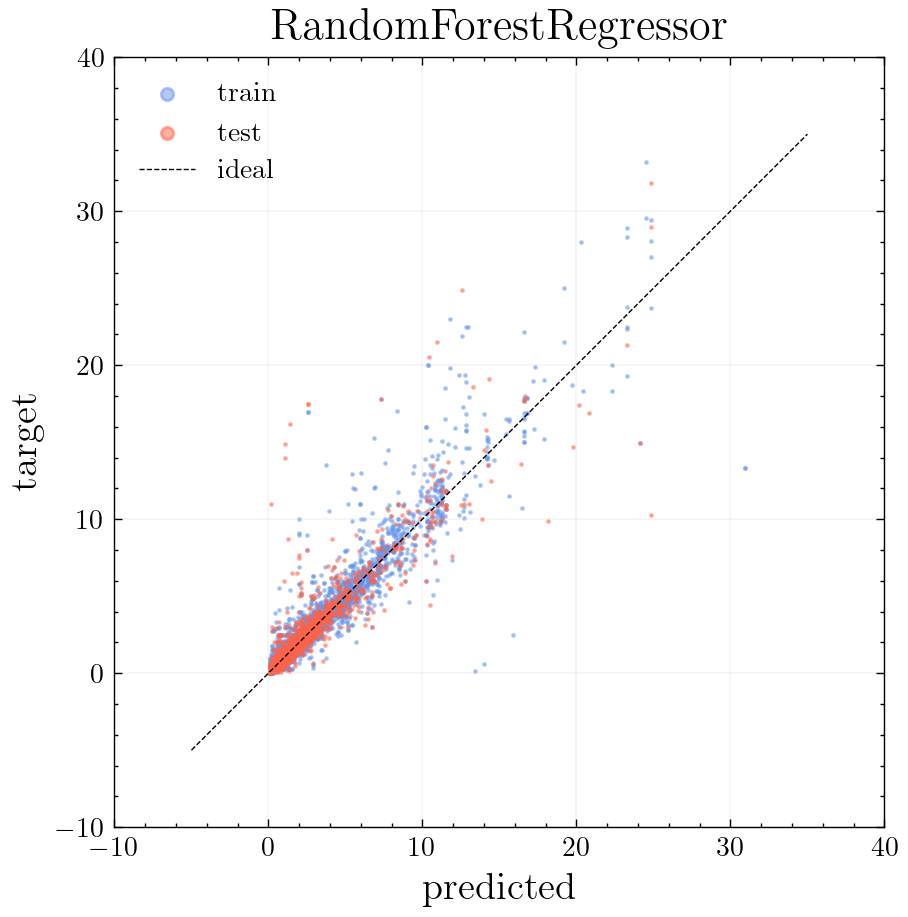

In [25]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = -10
up_lim = 40
delta = 5

ax.scatter(
    clf_forest.predict(X_train),
    y_train, 
    c='cornflowerblue', s=0.5,
    alpha=0.5,
    label='train'
)
ax.scatter(
    y_pred_forest,
    y_test, 
    c='tomato', s=0.5, 
    alpha=0.5,
    label='test'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('RandomForestRegressor', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

### RandomForest: `optuna` hyperparameters optimization

In [63]:
%%time
    # transform data so as not to waste time every trial!
X_trans_train = preprocessor.fit_transform(X_train)
X_trans_test = preprocessor.fit_transform(X_test)

print(f'Train size: {len(X_trans_train)}')
print(f'Test size:  {len(X_trans_test)}')

Train size: 18161
Test size:  4541
CPU times: user 172 ms, sys: 106 ms, total: 278 ms
Wall time: 7.26 s


In [68]:
def objective(trial, X_tr, y_tr, X_val, y_val, cv=5):
    
    n_estimators = trial.suggest_int('n_estimators', 10, 25)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    
    
    rf_classifier = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion='absolute_error',
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=FOREST_STATE    # fix random state for all trials
    )

    # cross-validation here is too long...(
    # 
#     cv_results = cross_validate(
#         rf_classifier, data_X, data_y, cv=cv, 
#         scoring='neg_mean_absolute_error'
#     )
    
#     return cv_results['test_score'].mean()

    # no cross-validation
    rf_classifier.fit(X_tr, y_tr)
    
    y_pred = rf_classifier.predict(X_val) 
    l1_val = np.abs(y_pred - y_val).mean()  # l1-score

    return l1_val

In [69]:
%%time

study = optuna.create_study(direction='minimize')  # to minimize l1-score

# cross-validation is too long :(
# kf = KFold(n_splits = 3, shuffle = True, random_state = 42)  # also fix `random_state`

study.optimize(
    lambda trial: objective(
        trial,
        X_trans_train, y_train,
        X_trans_test, y_test,
    ), 
    n_trials=50
)

[I 2024-02-20 18:14:31,663] A new study created in memory with name: no-name-6b036787-b387-4cd8-a8a0-098e0c8a6f36
[I 2024-02-20 18:16:07,175] Trial 0 finished with value: 0.2902922138387286 and parameters: {'n_estimators': 12, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2902922138387286.
[I 2024-02-20 18:19:16,077] Trial 1 finished with value: 0.36681452072230786 and parameters: {'n_estimators': 25, 'max_depth': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.2902922138387286.
[I 2024-02-20 18:21:05,627] Trial 2 finished with value: 0.31725982009941167 and parameters: {'n_estimators': 14, 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.2902922138387286.
[I 2024-02-20 18:24:12,521] Trial 3 finished with value: 0.261056195159082 and parameters: {'n_estimators': 23, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.261056195159082.
[I 2024-02-20 18:27:10,457] Trial 4 finished with value: 0.2698720040689876 and 

[I 2024-02-20 20:01:46,509] Trial 40 finished with value: 0.24718432323552084 and parameters: {'n_estimators': 16, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.24526671649216233.
[I 2024-02-20 20:03:51,797] Trial 41 finished with value: 0.24859456061807236 and parameters: {'n_estimators': 15, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.24526671649216233.
[I 2024-02-20 20:06:05,561] Trial 42 finished with value: 0.24718432323552084 and parameters: {'n_estimators': 16, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.24526671649216233.
[I 2024-02-20 20:08:09,852] Trial 43 finished with value: 0.2693617192468619 and parameters: {'n_estimators': 15, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 34 with value: 0.24526671649216233.
[I 2024-02-20 20:09:43,546] Trial 44 finished with value: 0.264942514354067 and parameters: {'n_estimators': 11, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 34 with v

CPU times: user 2h 7min 35s, sys: 1.9 s, total: 2h 7min 37s
Wall time: 2h 8min 5s


### DataFrame with optuna trials results

In [73]:
    # obtaining DataFrame with trials results
optuna_trials_df = study.trials_dataframe().drop(
    ['datetime_start', 'datetime_complete', 'duration'],
    axis=1
)  # exclude columns
optuna_trials_df = optuna_trials_df.loc[optuna_trials_df['state'] == 'COMPLETE']  # keep only results that did not prune
optuna_trials_df = optuna_trials_df.drop('state', axis=1)  # exclude state column
optuna_trials_df = optuna_trials_df.sort_values('value')  # sort based on l1-loss

In [82]:
    # DataFrame with results can be loaded from `optuna/`
# directory = 'optuna'
# filename = f'01_randomforest_optuna_res.txt'

# optuna_trials_df = pd.read_csv(os.path.join(directory, filename + '.csv'), index_col=0)

In [83]:
optuna_trials_df.head()

,value,params_max_depth,params_min_samples_leaf,params_n_estimators
number,,,,
34,0.245267,19,2,22
37,0.245621,19,2,19
49,0.246895,20,2,23
48,0.246895,20,2,23
40,0.247184,18,2,16


In [76]:
    # saving DataFrame
# directory = 'optuna'
# filename = f'01_randomforest_optuna_res.txt'

# optuna_trials_df.to_csv(os.path.join(directory, filename + '.csv'), index=False)  # save to csv file

In [134]:
plot_optimization_history(study)

### Test the best RandomForest configuration

In [101]:
_, max_depth_best, min_samples_leaf_best, n_est_best = np.array(optuna_trials_df[
    optuna_trials_df['value'] == min(optuna_trials_df['value'])  # find the trial with minimal loss
])[0]  # best params for RandomForest

In [106]:
%%time

best_rf = RandomForestRegressor(
    n_estimators=int(n_est_best),
    criterion='absolute_error',
    max_depth=int(max_depth_best),
    min_samples_leaf=int(min_samples_leaf_best),
    random_state=FOREST_STATE    # fix random state for all trials
)

best_rf.fit(X_trans_train, y_train)

CPU times: user 3min 3s, sys: 56.9 ms, total: 3min 3s
Wall time: 3min 4s


RandomForestRegressor(criterion='absolute_error', max_depth=19,
                      min_samples_leaf=2, n_estimators=22, random_state=78)

In [113]:
y_pred_best = best_rf.predict(X_trans_test) 
l1_val_best = np.abs(y_pred_best - y_test).mean()  # l1-score

print(f'l1-score for BEST forest model: {l1_val_best:.6f}')
print(f'R^2 score for BEST forest model: {best_rf.score(X_trans_test, y_test):.6f}')

l1-score for BEST forest model: 0.245267
R^2 score for BEST forest model: 0.853076


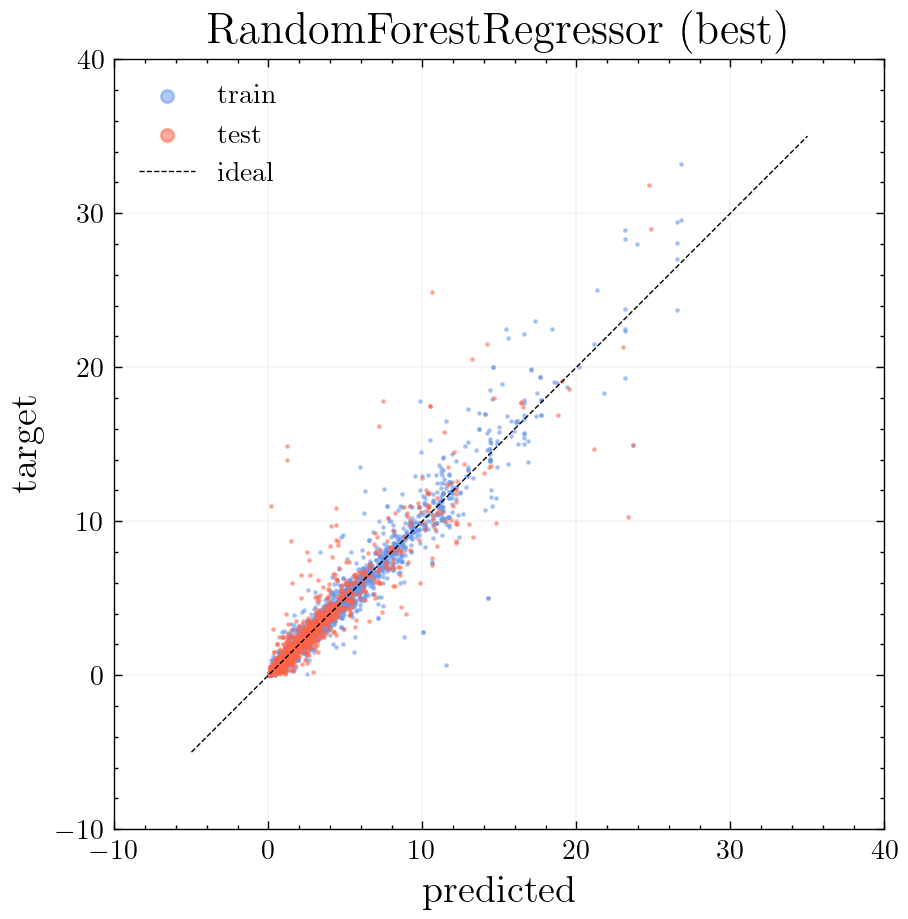

In [114]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = -10
up_lim = 40
delta = 5

ax.scatter(
    best_rf.predict(X_trans_train),
    y_train, 
    c='cornflowerblue', s=0.5,
    alpha=0.5,
    label='train'
)
ax.scatter(
    y_pred_best,
    y_test, 
    c='tomato', s=0.5, 
    alpha=0.5,
    label='test'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('RandomForestRegressor (best)', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

### Comparison of two forests 

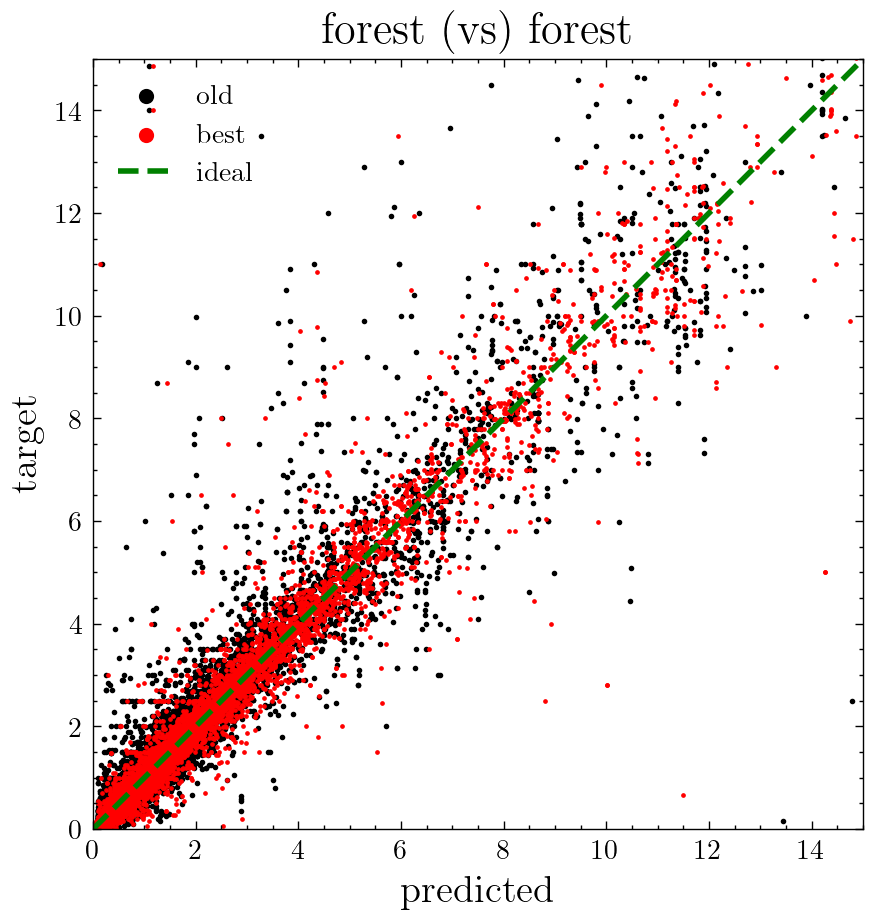

In [133]:
    # predictions (on all data) visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = 0
up_lim = 15

old_color = 'k'
best_color = 'r'
ms = 1

    # old model
ax.scatter(
    clf_forest.predict(X_train),
    y_train, 
    c=old_color, s=ms,
)
ax.scatter(
    y_pred_forest,
    y_test, 
    c=old_color, s=ms, 
    label='old'
)

    # best model
ax.scatter(
    best_rf.predict(X_trans_train),
    y_train, 
    c=best_color, s=0.5,
    alpha=1,
)
ax.scatter(
    y_pred_best,
    y_test, 
    c=best_color, s=0.5, 
    alpha=1,
    label='best'
)

    # ideal predictor
ax.plot(
    [low_lim, up_lim],
    [low_lim, up_lim],
    c='g', linestyle='--', lw=2, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('forest (vs) forest', fontsize=lables_fs)

# ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

### Results

`PandomForest` with _optimal_ parameters obtained via `optuna` is not much better than the initial forest with _random_ parameters:(

$L_1$-loss becomes lower (for _the best model_), but not dramatically: `0.262` vs `0.245` 

**Interpretation:** predictions (of _the best model_) for `price` becomes closer to the true values by `20k` rubles (average)

### Feature importance

In [165]:
feature_names = num_cols.copy()
feature_names.extend([f'cat_{i + 1}' for i in range(X_trans_train.shape[1] - len(num_cols))])

In [166]:
rf_importances = best_rf.feature_importances_
rf_std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)

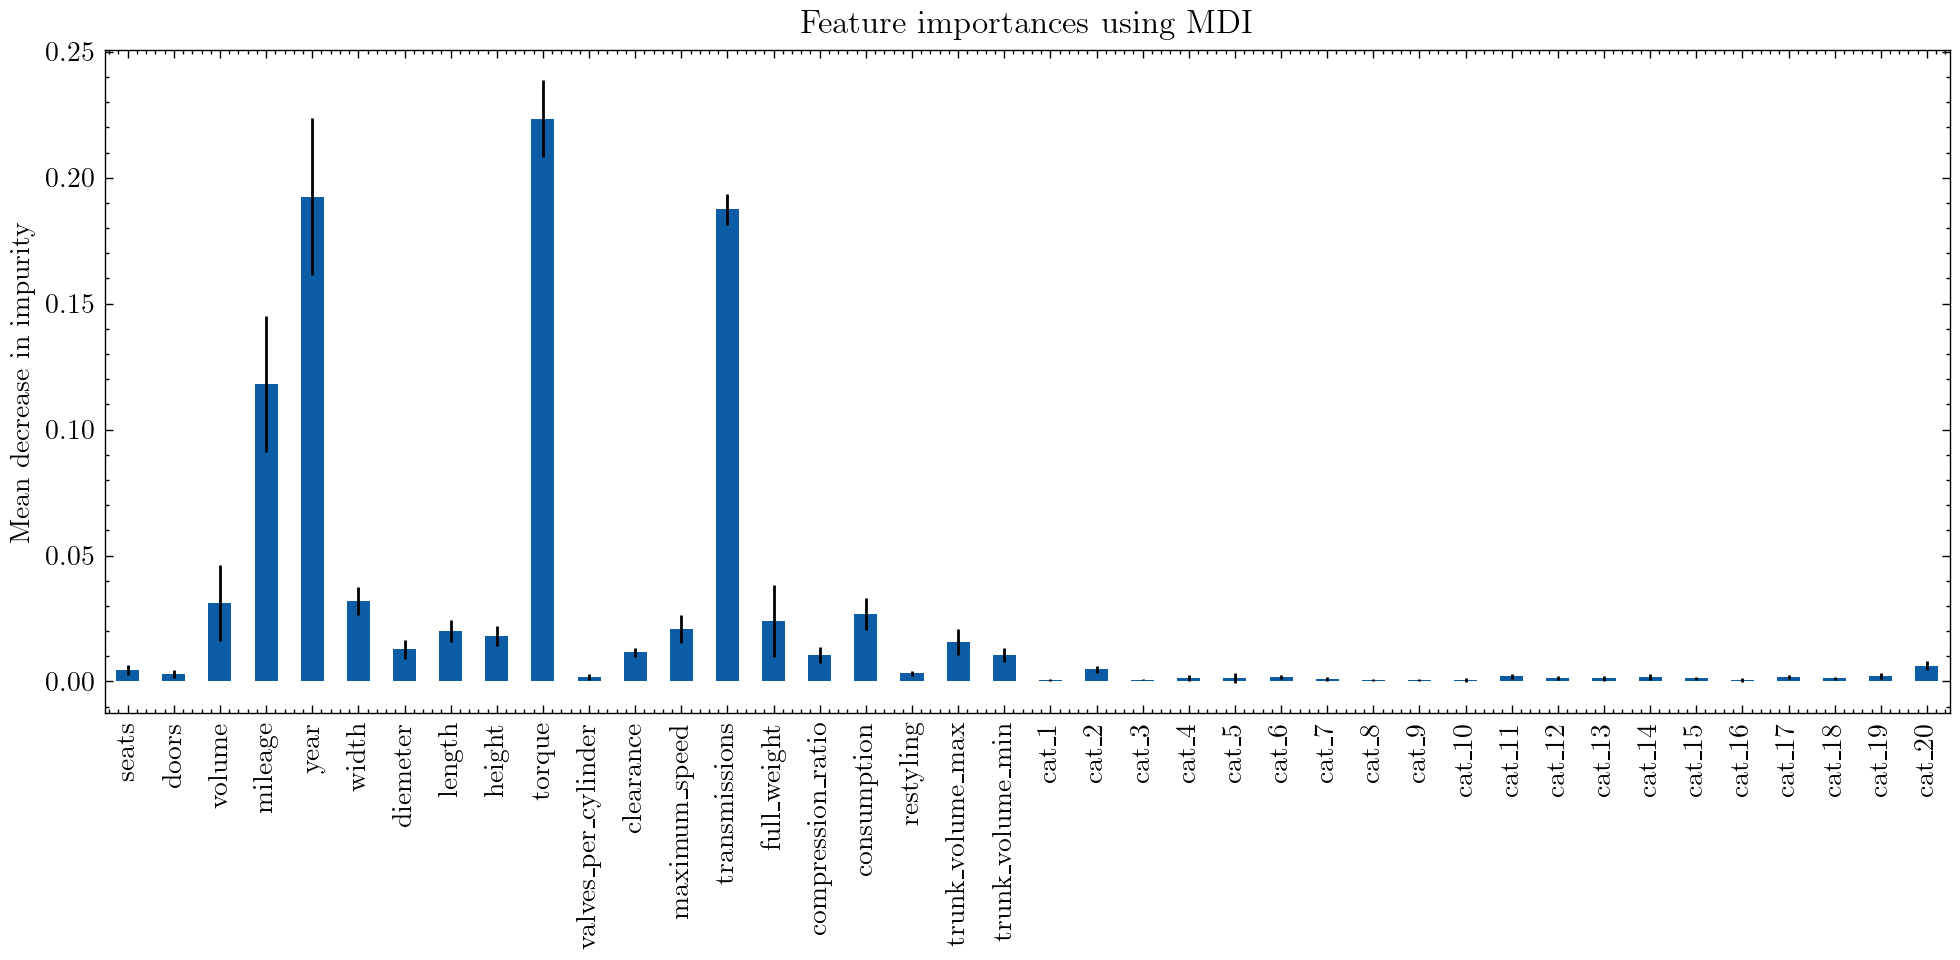

In [170]:
best_forest_importances = pd.Series(rf_importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10, 5))
best_forest_importances.plot.bar(yerr=rf_std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

Top of the most important features for price prediction:

1. `torque`
2. `year`
3. `transmissions`